#### Maps of surface precipitation in prognostic runs for baseline physics, RF, and NN ensemble

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import cftime
import intake
import fsspec
import numpy as np
import pandas as pd
import seaborn as sb
import xarray as xr

import fv3viz as viz
from vcm.catalog import catalog

def weighted_average(array, weights, axis=None):
    return np.nansum(array * weights, axis=axis) / np.nansum(weights, axis=axis)


MAPPABLE_VAR_KWARGS = {
    "coord_x_center": "x",
    "coord_y_center": "y",
    "coord_x_outer": "x_interface",
    "coord_y_outer": "y_interface",
    "coord_vars": {
        "lonb": ["y_interface", "x_interface", "tile"],
        "latb": ["y_interface", "x_interface", "tile"],
        "lon": ["y", "x", "tile"],
        "lat": ["y", "x", "tile"],
    },
}

%matplotlib inline
import matplotlib.pyplot as plt
import fsspec
import xarray as xr
import numpy as np

from vcm.catalog import catalog


timescales = [1, 3, 6, 12]
paths = [
    f"gs://vcm-ml-public/argo/prog-report-nudge-to-3km-timescale-sensitivity/tau-{tau}-hr"
    for tau in timescales
]


grid = catalog["grid/c48"].read()
area = grid["area"]

land_sea_mask = catalog["landseamask/c48"].read()["land_sea_mask"]

with fsspec.open("gs://vcm-ml-public/argo/2021-05-04-nudge-to-c3072-prog-timescales/physics-on-baseline/diags.nc", "rb") as f:
    diags_baseline = xr.open_dataset(f).load()
    
diags = []
for tau, path in zip(timescales, paths):
    print(path)
    with fsspec.open(f"{path}/diags.nc", "rb") as f:
        diags.append(xr.open_dataset(f).load())
    
    
with fsspec.open("gs://vcm-ml-public/argo/prog-report-nudge-to-3km-nn-rf-comparison/baseline/diags.nc", "rb") as f:
    diags_baseline = xr.open_dataset(f).load()
    
    
grid = catalog["grid/c48"].read()
area = grid["area"]

land_sea_mask = catalog["landseamask/c48"].read()["land_sea_mask"]

gs://vcm-ml-public/argo/prog-report-nudge-to-3km-timescale-sensitivity/tau-1-hr
gs://vcm-ml-public/argo/prog-report-nudge-to-3km-timescale-sensitivity/tau-3-hr
gs://vcm-ml-public/argo/prog-report-nudge-to-3km-timescale-sensitivity/tau-6-hr


_call non-retriable exception: 
Traceback (most recent call last):
  File "/home/AnnaK/miniconda3/envs/fv3net/lib/python3.7/site-packages/gcsfs/core.py", line 507, in _call
    self.validate_response(status, contents, json, path, headers)
  File "/home/AnnaK/miniconda3/envs/fv3net/lib/python3.7/site-packages/gcsfs/core.py", line 1230, in validate_response
    raise HttpError({"code": status})
gcsfs.utils.HttpError


HttpError: 

#### RMSE maps (reproduces the prognostic report)

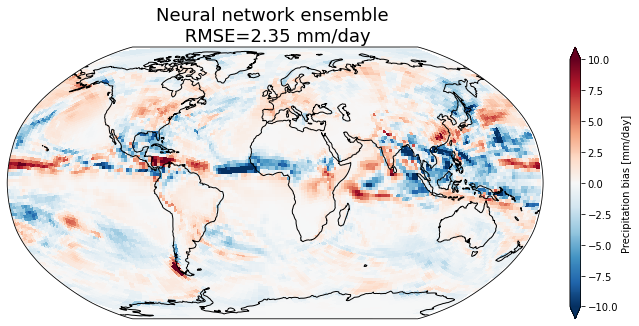

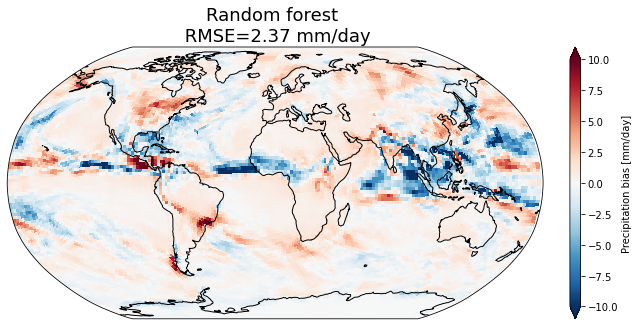

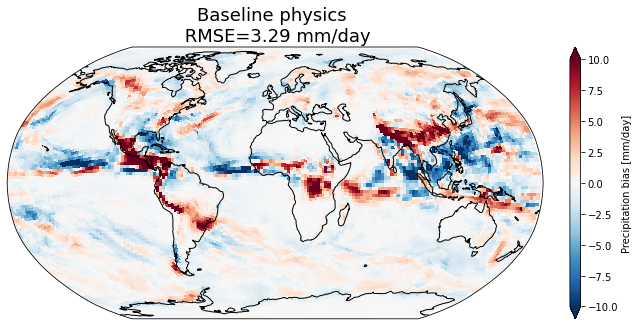

In [4]:
var = "total_precip_to_surface_time_mean_bias"
vmax = 10
fig_size = (12,5)

labels = ["1 hr", "3 hr", "6 hr", "12 hr", "Baseline physics"]
datasets = diags + [diags_baseline]

for label, ds in zip(labels, datasets):
    mappable_var = viz.mappable_var(ds, var, **MAPPABLE_VAR_KWARGS)
    
    rmse = np.sqrt(weighted_average(ds[var]**2, area))
    bias = weighted_average(ds[var], area)
    
    fig, _, _, _, _ = viz.plot_cube(
        mappable_var,
        vmax=vmax,
        cbar_label="Precipitation bias [mm/day]",
    )
    
    fig.set_size_inches(fig_size)
    
    title = f"{label} \n RMSE={rmse:3.2f} mm/day"
    plt.title(title, fontsize=18)
    plt.savefig(f"figures/prognostic_sfc_precip_rmse_map_{label.replace(' ', '_').lower()}.png", bbox_inches = "tight")
    plt.show()
    

#### Bar plot for domain averages of precip bias and RMSE

In [ ]:
var= "total_precip_to_surface_time_mean_bias"

domain_avg_biases = []


labels = ["1 hr", "3 hr", "6 hr", "12 hr", "Baseline physics"]
datasets = diags + [diags_baseline]

for domain in ["global", "land", "ocean"]:
    for label, ds in zip(labels, datasets):
        if domain == "global":
            area_masked = area
            da = ds[var]
        elif domain == "land":
            area_masked = area.where(land_sea_mask==1)
            da = ds[var].where(land_sea_mask==1)
        elif domain == "ocean":
            area_masked = area.where(land_sea_mask==0)
            da = ds[var].where(land_sea_mask==0)            
        bias = ((da * area_masked).sum(skipna=True, dim=["tile", "x", "y"]) / area_masked.sum(skipna=True)).item()
        rmse = np.sqrt( 
            (da**2 * area_masked).sum(skipna=True, dim=["tile", "x", "y"]) / area_masked.sum(skipna=True)
        ).item()        
        domain_avg_biases.append([domain, label, rmse, bias])
        
biases = pd.DataFrame(domain_avg_biases, columns=["domain", "dataset", "RMSE", "bias"])


In [ ]:
biases = pd.DataFrame(domain_avg_biases, columns=["domain", "dataset", "RMSE", "bias"])
biases

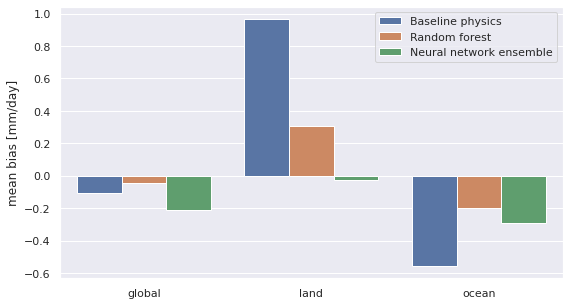

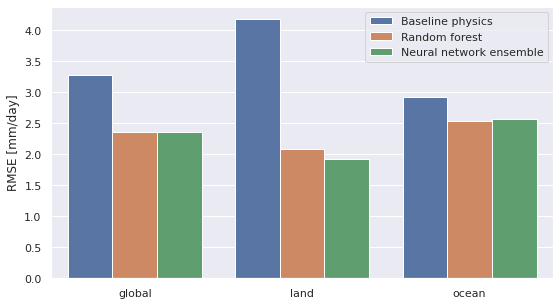

In [28]:

sb.set(font_scale = 1)
figsize=(9,5)

biases = pd.DataFrame(domain_avg_biases, columns=["domain", "dataset", "RMSE", "bias"])

fig = plt.figure(figsize=figsize)
f = sb.barplot(
    x="domain", 
    y="bias", 
    hue="dataset", 
    data=biases,
)
f.set_xlabel("", fontsize=20)
f.set_ylabel("mean bias [mm/day]")
f.legend(loc="upper right")
#f.legend( bbox_to_anchor=(1.05, 1), loc='upper left',)

fig.savefig(f"figures/prognostic_sfc_precip_bias_bar_plot.png")


fig = plt.figure(figsize=figsize)
f = sb.barplot(
    x="domain", 
    y="RMSE", 
    hue="dataset", 
    data=biases,
)
f.set_xlabel("", fontsize=20)
f.set_ylabel("RMSE [mm/day]")
#f.set_ylim([0, 6])
f.legend(loc="upper right")
#f.legend( bbox_to_anchor=(1.05, 1)), loc='upper left',)
fig.savefig(f"figures/prognostic_sfc_precip_rmse_bar_plot.png")

Combine subfigures

<Figure size 432x288 with 0 Axes>

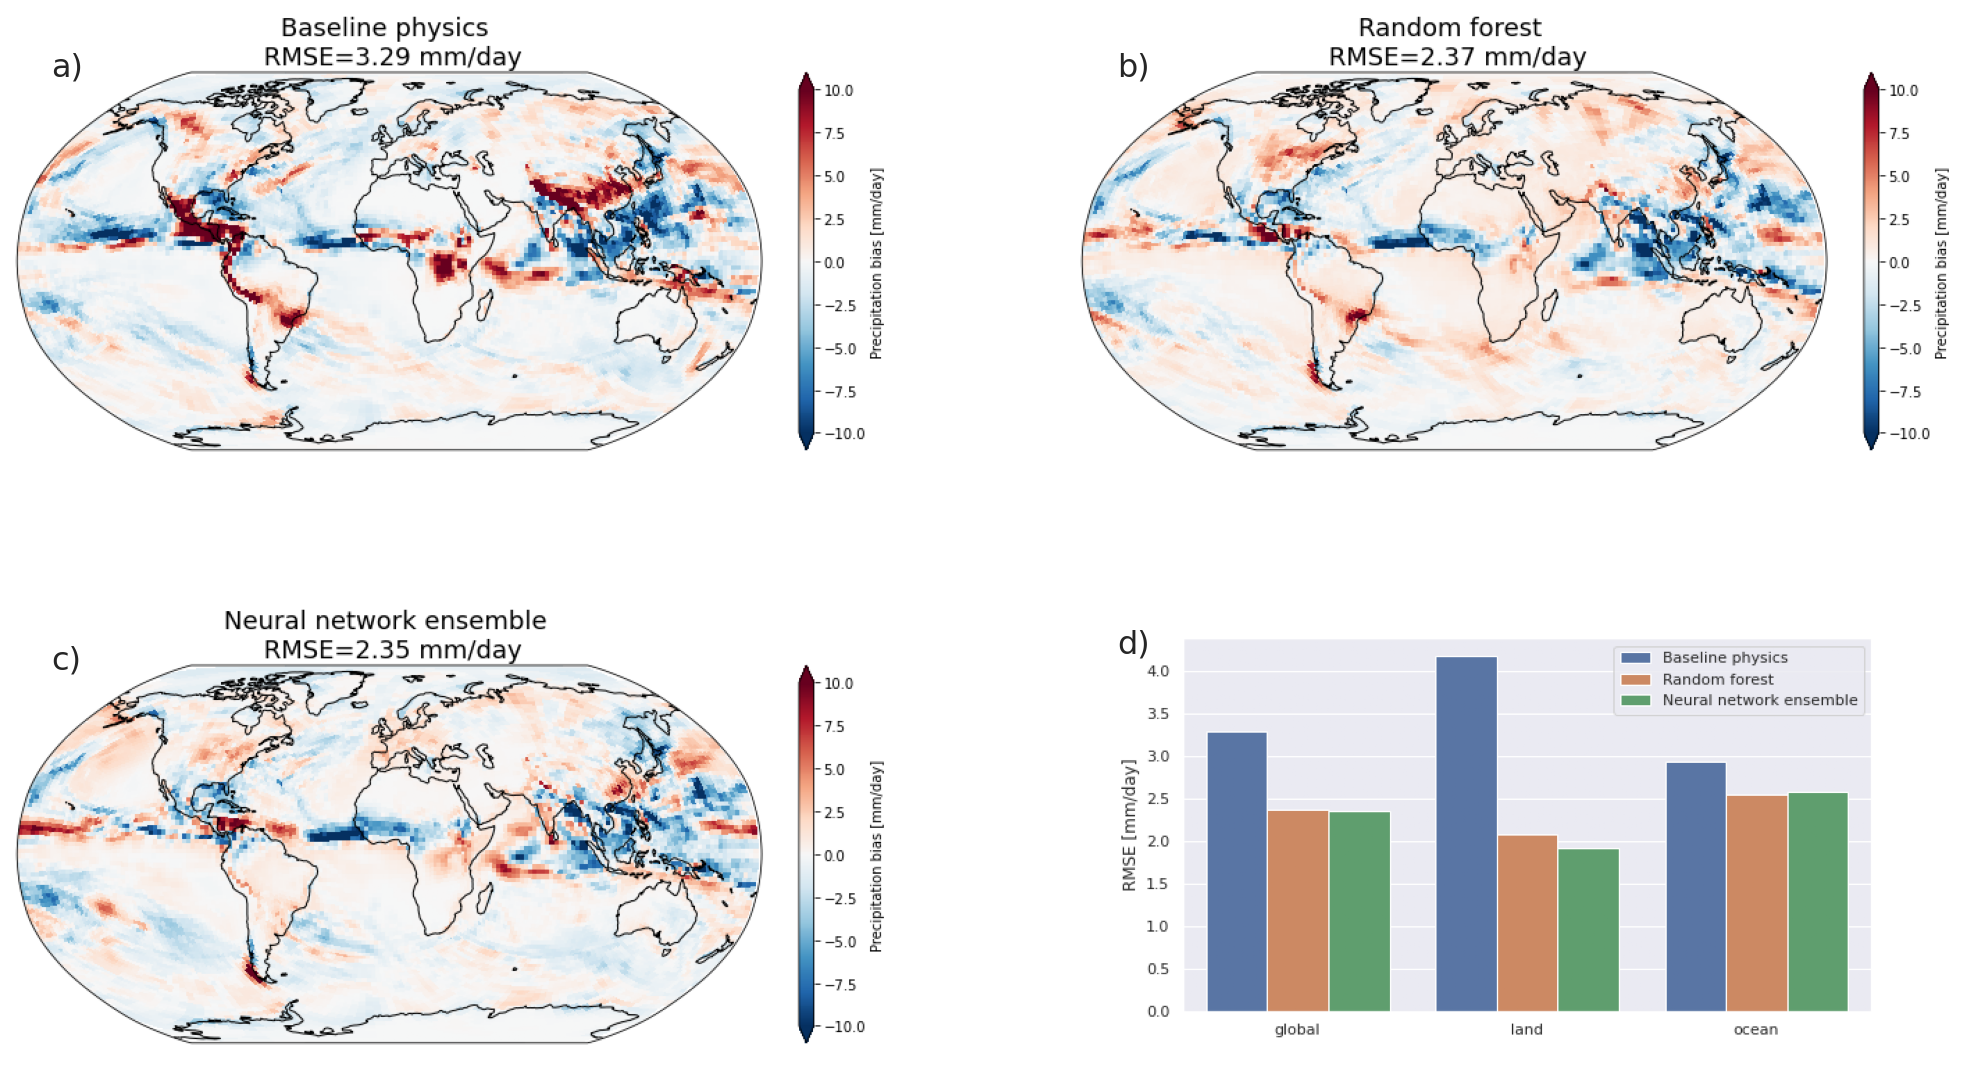

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


baseline = mpimg.imread("figures/prognostic_sfc_precip_rmse_map_baseline_physics.png")
rf = mpimg.imread("figures/prognostic_sfc_precip_rmse_map_random_forest.png")
nn = mpimg.imread("figures/prognostic_sfc_precip_rmse_map_neural_network_ensemble.png")
bar = mpimg.imread("figures/prognostic_sfc_precip_rmse_bar_plot.png")
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,2, figsize=(35,20)) 
plt.axis('off')

axarr[0][0].imshow(baseline)
axarr[0][0].set_axis_off()
axarr[0][0].text(0.05, 0.9, "a)", va='top', fontsize=32, transform=axarr[0][0].transAxes)

axarr[0][1].imshow(rf)
axarr[0][1].set_axis_off()
axarr[0][1].text(0.05, 0.9, "b)", va='top', fontsize=32, transform=axarr[0][1].transAxes)

axarr[1][0].imshow(nn)
axarr[1][0].set_axis_off()
axarr[1][0].text(0.05, 0.9, "c)", va='top', fontsize=32, transform=axarr[1][0].transAxes)


axarr[1][1].imshow(bar)
axarr[1][1].set_axis_off()
axarr[1][1].text(0.05, 0.9, "d)", va='top', fontsize=32, transform=axarr[1][1].transAxes)

plt.savefig("figures/composite_sfc_precip_pattern_error.png")